<a href="https://colab.research.google.com/github/beercafeguy/PyMLLab/blob/master/practice/classifier_metric_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl

## Read MNIST data

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784',version=1,as_frame=False)
mnist.keys()

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X,y = mnist['data'],mnist['target']

In [4]:
X.shape # 784 =  28 * 28 pixels

(70000, 784)

In [5]:
y.shape

(70000,)

In [6]:
print(y)

['5' '0' '4' ... '4' '5' '6']


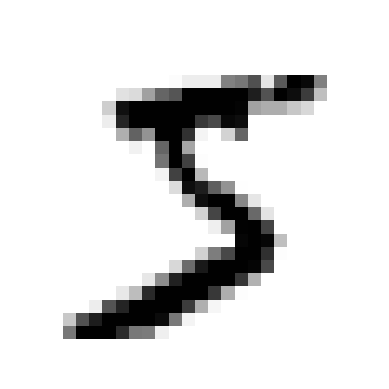

In [7]:
# display one digit

%matplotlib inline

sample_image_data = X[0]
sample_image = sample_image_data.reshape(28,28)
plt.imshow(sample_image,cmap=mpl.cm.binary)
plt.axis("off")
plt.show()

In [8]:
print(y[0])

5


In [9]:
# the target is goven as string to we need to convert that to int
y = y.astype(np.uint8)

In [10]:
y

array([5, 0, 4, ..., 4, 5, 6], dtype=uint8)

In [11]:
X_train,X_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]

### Train a binary classifier

Here we have 10 targets but to make it binary, will make all the 5's as 1 and non 5's as 0. So we need to predict if the given digit is 5 or not

In [12]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [13]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(max_iter=1000,tol=0.001,random_state=2023)
sgd.fit(X_train,y_train_5)

SGDClassifier(random_state=2023)

In [14]:
y_pred = sgd.predict([X[0].reshape(28*28)])
y_pred # we already know this is 5

array([ True])

In [15]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd,X_train,y_train_5,cv=5,scoring='accuracy')

array([0.97183333, 0.96525   , 0.94733333, 0.93533333, 0.96691667])

## Measuring accuracy usng cross validation

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfold = StratifiedKFold(n_splits=3,shuffle=True,random_state=2023)

for train_index,test_index in skfold.split(X_train,y_train_5):
  print('train_index',train_index)
  print('test_index',test_index)
  clone_classifier = clone(sgd)

  X_train_kfold = X_train[train_index]
  X_test_kfold = X_train[test_index]
  print(X_train_kfold.shape)
  print(X_test_kfold.shape)
  y_train_kfold = y_train_5[train_index]
  y_test_kfold = y_train_5[test_index]
  print(y_train_kfold.shape)
  print(y_test_kfold.shape)

  clone_classifier.fit(X_train_kfold,y_train_kfold)
  y_pred_kfold = clone_classifier.predict(X_test_kfold)
  n_correct = sum(y_pred_kfold==y_test_kfold)

  print("Accuracy : ",n_correct/len(y_test_kfold))

train_index [    0     1     2 ... 59994 59997 59998]
test_index [    4     7     8 ... 59995 59996 59999]
(40000, 784)
(20000, 784)
(40000,)
(20000,)
Accuracy :  0.9617
train_index [    1     2     4 ... 59997 59998 59999]
test_index [    0     3     6 ... 59990 59993 59994]
(40000, 784)
(20000, 784)
(40000,)
(20000,)
Accuracy :  0.9527
train_index [    0     3     4 ... 59995 59996 59999]
test_index [    1     2     5 ... 59989 59997 59998]
(40000, 784)
(20000, 784)
(40000,)
(20000,)
Accuracy :  0.95075


In [17]:
## Dummy estimator which always predicts False

from sklearn.base import BaseEstimator

class DummyClassifier(BaseEstimator):

  def fit(self,X,y=None):
    pass

  def predict(self,X):
    return np.zeros((len(X),1),dtype=bool)

In [18]:
dumb_clf = DummyClassifier()
cross_val_score(dumb_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

# Cofusion Matrix

In [19]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd,X_train,y_train_5,cv=3)
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [20]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5,y_train_pred)

array([[53205,  1374],
       [ 1101,  4320]])

In [21]:
# confussion metrix for perfect predictions

confusion_matrix(y_train_5,y_train_5)

array([[54579,     0],
       [    0,  5421]])

## Precision and Recall

In [22]:
# precision = TP / (TP+FP)
# Recall = TP/(TP+FN)

In [23]:
from sklearn.metrics import precision_score,recall_score

cm = confusion_matrix(y_train_5,y_train_pred)
print(cm)
print("Calculated Precision : ",(4320/(4320+1374))) # TP / (TP + FP)
print("Formula Precision : ",precision_score(y_train_5,y_train_pred))

[[53205  1374]
 [ 1101  4320]]
Calculated Precision :  0.7586933614330874
Formula Precision :  0.7586933614330874


In [24]:
cm = confusion_matrix(y_train_5,y_train_pred)
print(cm)
print("Calculated Recall : ",(4320/(4320+1101))) # TP / (TP + FN)
print("Formula Recall : ",recall_score(y_train_5,y_train_pred))

[[53205  1374]
 [ 1101  4320]]
Calculated Recall :  0.7969009407858328
Formula Recall :  0.7969009407858328


## F1-score

In [25]:
from sklearn.metrics import f1_score

print("Calculated F1 : ",2 *  0.7586933614330874 * 0.7969009407858328 /(0.7586933614330874+0.7969009407858328) )
print("Formula F1 : ",f1_score(y_train_5,y_train_pred))

Calculated F1 :  0.777327935222672
Formula F1 :  0.777327935222672


# Precision Recall Tradeoff

In [26]:
y_pred_scores = sgd.decision_function([X[0]]) # this gives you actual score which later will be coonverted into prediction using a threshold
y_pred_scores

array([767.13846228])

In [27]:
threshold = 0 # default value

y_pred_scores > threshold

array([ True])

In [28]:
threshold = 8000 # default value

y_pred_scores > threshold

array([False])

In [29]:
y_pred_scores = cross_val_predict(sgd,X_train,y_train_5,cv=3,method='decision_function')
y_pred_scores

array([ 10039.29544457, -16735.6013513 , -32307.88690651, ...,
        12201.58775094,  -6858.53784519,  -9365.72501489])

In [30]:
from sklearn.metrics import precision_recall_curve

precision,recall,thresholds = precision_recall_curve(y_train_5,y_pred_scores)

In [31]:
def plot_precision_recall_threshold(pr,re,th):
  plt.plot(th,pr[:-1],"b--",label = 'Precision',linewidth=2)
  plt.plot(th,re[:-1],"g-",label = 'Recall',linewidth=2)
  plt.legend(loc="center right",fontsize=16)
  plt.xlabel("Threshold",fontsize=16)
  plt.grid(True)
  plt.axis([-30000,30000,0,1])

In [32]:
precision.shape,recall.shape,thresholds.shape

((60001,), (60001,), (60000,))

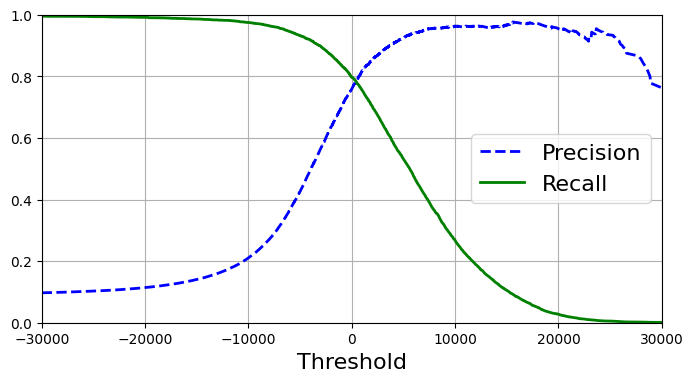

In [33]:
plt.figure(figsize=(8, 4))
plot_precision_recall_threshold(precision,recall,thresholds)

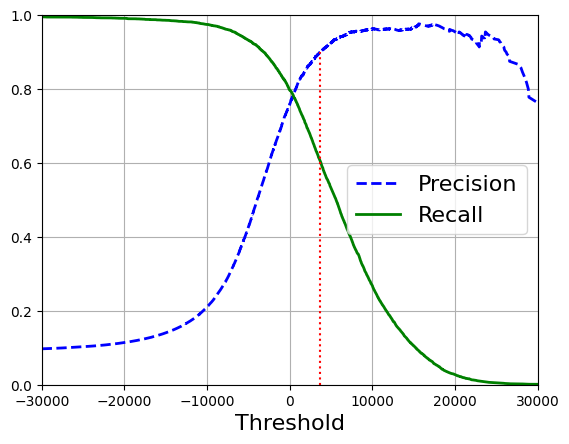

In [34]:
# get recalls when precision is more then 90%
recall_90_precision = recall[np.argmax(precision >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precision >= 0.90)]

plot_precision_recall_threshold(precision,recall,thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")

In [39]:
threshold_90_precision

3693.8293723259853

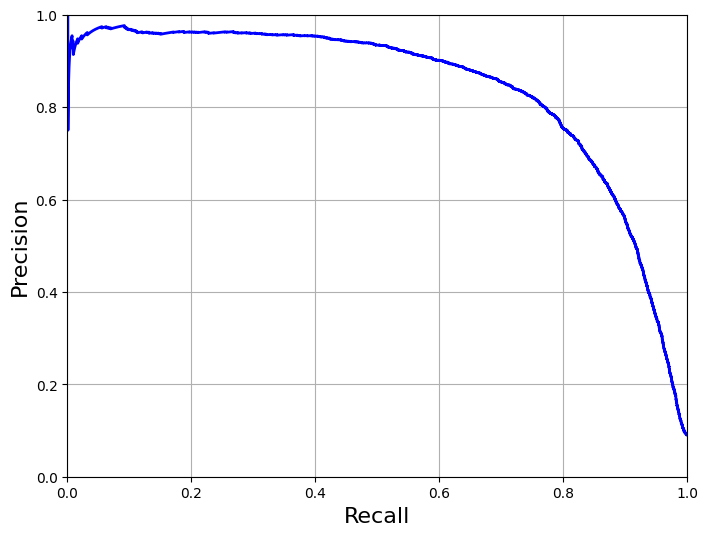

In [37]:
def plot_precision_recall_curve(prec,rec):
  plt.plot(rec, prec, "b-", linewidth=2)
  plt.xlabel("Recall", fontsize=16)
  plt.ylabel("Precision", fontsize=16)
  plt.axis([0, 1, 0, 1])
  plt.grid(True)


plt.figure(figsize=(8,6))
plot_precision_recall_curve(precision,recall)

## ROC Curve

In [41]:
from sklearn.metrics import roc_curve

fpr,tpr,thresholds = roc_curve(y_train_5,y_pred_scores)

# FPR = FP / FP + TN (FP out of all the actual negatives)
# TPR = TP / TP + FN (true positives out of all the actual positives) - recall

fpr,tpr,thresholds

(array([0.        , 0.        , 0.        , ..., 0.99811283, 0.99811283,
        1.        ]),
 array([0.00000000e+00, 1.84467810e-04, 9.22339052e-04, ...,
        9.99815532e-01, 1.00000000e+00, 1.00000000e+00]),
 array([  38484.42175818,   38483.42175818,   31217.67910317, ...,
         -79367.52821516,  -79482.29070441, -126344.69060604]))

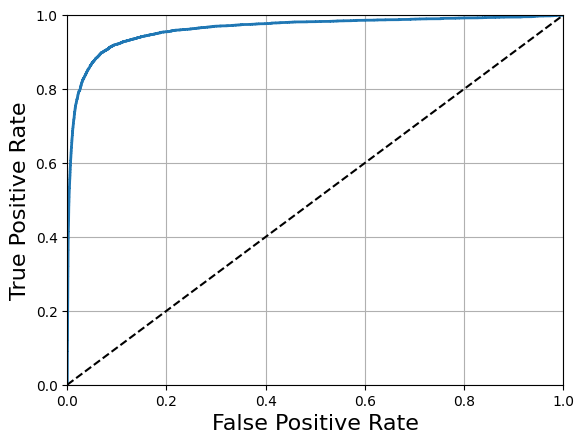

In [46]:
def plot_roc_curve(_fpr,_tpr,_label=None):
  plt.plot(_fpr,_tpr,linewidth=2,label=_label)
  plt.plot([0,1],[0,1],'k--') # diagonal for a dumb classifier
  plt.axis([0,1,0,1])
  plt.xlabel('False Positive Rate', fontsize=16) # Fall-Out
  plt.ylabel('True Positive Rate', fontsize=16)    # Recall
  plt.grid(True)

plot_roc_curve(fpr,tpr,_label='ROC Curve')

In [47]:


from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_pred_scores)



0.9633563460298149

# Train Random forest

In [48]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf_prob_scores = cross_val_predict(rf,X_train,y_train_5,cv=3,method='predict_proba')
rf_prob_scores

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [50]:
rf_scores = rf_prob_scores[:,1] # probability of positive class
fpr_rf,tpr_rf,thresholds_rf = roc_curve(y_train_5,rf_scores)

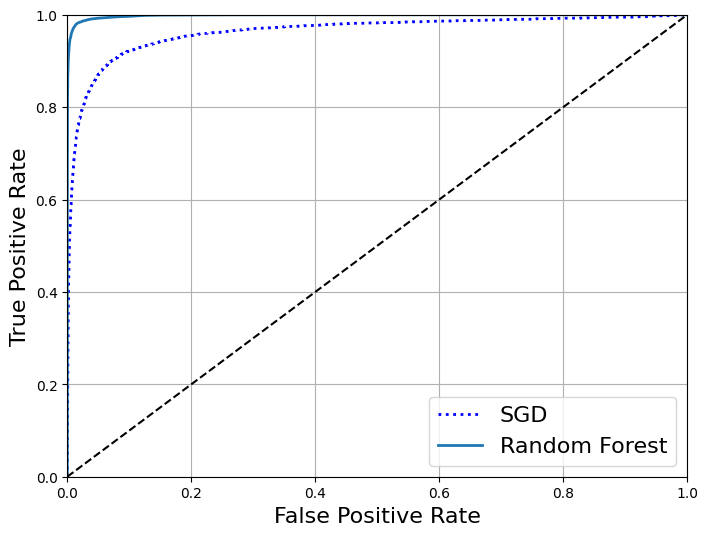

In [52]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_rf, tpr_rf, _label="Random Forest")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)

In [53]:
roc_auc_score(y_train_5, rf_scores)

0.9983436731328145

## Multi class classification